## Well Testing HW 1

Completed by  ***Brecken Runquist*** 

In [49]:
import numpy as np
from scipy.special import expi
import matplotlib.pyplot as plt
import scipy.optimize as opt

Provided Data

In [50]:
q = 300 # stb/d
Pi = 4000 # psia
A = 80 # acres
rw = 0.25 # ft
h = 50 # ft
phi = 0.2 # fraction
k = 55 # md
ct = 15e-6 # psi^-1
Bo = 1.2 # rb/stb
mu = 1.5 # cp

In [51]:
def drainage_radius_from_area(area_acres: float) -> float:
    return float(np.sqrt(area_acres * 43560.04 / np.pi))

def t_infinite_acting_hr(phi: float, mu_cp: float, ct_psi_inv: float, area_acres: float, k_md: float) -> float:
    """End of infinite-acting radial flow (hours)."""
    return float(121.0 * phi * mu_cp * ct_psi_inv * area_acres * 43560.04 / k_md)

def pavg_closed_system(psia_pi: float, t_hr, q_stbd: float, bo_rb_stb: float, area_acres: float, h_ft: float, phi: float, ct_psi_inv: float):
    """Average reservoir pressure vs time for a closed slightly-compressible liquid system."""
    t_hr = np.asarray(t_hr, dtype=float)
    pore_volume_rb = (area_acres * 43560.04 * h_ft * phi) / 5.615
    pavg = psia_pi - (q_stbd * bo_rb_stb) * (t_hr / 24.0) / (pore_volume_rb * ct_psi_inv)
    # print(f'pavg = {pavg} at time {t_hr} hr')
    return pavg

def pwf_infinite_acting(t_hr, q_stbd: float, psia_pi: float, k_md: float, h_ft: float, phi: float, mu_cp: float, ct_psi_inv: float, rw_ft: float, bo_rb_stb: float):
    """Infinite-acting (line-source) wellbore drawdown using exponential integral."""
    t_hr = np.asarray(t_hr, dtype=float)
    tD = 0.0002637 * k_md * t_hr / (phi * mu_cp * ct_psi_inv * rw_ft**2)
    pD = -0.5 * expi(-1.0 / (4.0 * tD))
    delta_p = 141.2 * (q_stbd * bo_rb_stb * mu_cp) / (k_md * h_ft) * pD
    return psia_pi - delta_p

def pwf_pseudosteady_centered_well(t_hr, q_stbd: float, psia_pi: float, area_acres: float, k_md: float, h_ft: float, phi: float, mu_cp: float, ct_psi_inv: float, rw_ft: float, bo_rb_stb: float, skin: float = 0.0):
    """Pseudo-steady approximation for a closed circular reservoir with a centered well."""
    t_hr = np.asarray(t_hr, dtype=float)
    re_ft = drainage_radius_from_area(area_acres)
    p_avg = pavg_closed_system(psia_pi, t_hr, q_stbd, bo_rb_stb, area_acres, h_ft, phi, ct_psi_inv)
    dd = 141.2 * (q_stbd * bo_rb_stb * mu_cp) / (k_md * h_ft) * (np.log(re_ft / rw_ft) - 0.75 + skin)
    return p_avg - dd

def pwf_pseudosteady_shape_factor(t_hr, q_stbd: float, psia_pi: float, area_acres: float, k_md: float, h_ft: float, phi: float, mu_cp: float, ct_psi_inv: float, rw_ft: float, bo_rb_stb: float, shape_factor_CA: float, skin: float = 0.0):
    """Pseudo-steady approximation using a Dietz/Dake-style drainage shape factor C_A.

    Dake (Fundamentals of Reservoir Engineering) commonly writes the pseudo-steady drawdown as:

        p_wf = p_i - (q μ B)/(2π k h) * [ 1/2 ln(4A/(γ C_A r_w^2)) + 2π k t/(φ μ c_t A) + s ] 

    This implementation is algebraically equivalent, but we compute the time-dependent depletion
    through p_avg(t) (material balance) and use the constant drawdown term:

        p_avg(t) - p_wf(t) = (141.2 q B μ)/(k h) * [ 1/2 ln(4A/(γ C_A r_w^2)) + s ]

    Notes:
    - γ here is Euler's constant in Dake's notation: γ = e^0.57721566 ≈ 1.781.
    - Units: A is in ft^2 internally, r_w in ft.
    """
    t_hr = np.asarray(t_hr, dtype=float)
    area_ft2 = area_acres * 43560.04
    gamma_euler = float(np.exp(0.5772156649015329))  # ≈ 1.781
    p_avg = pavg_closed_system(psia_pi, t_hr, q_stbd, bo_rb_stb, area_acres, h_ft, phi, ct_psi_inv)
    shape_term = 0.5 * np.log((4.0 * area_ft2) / (gamma_euler * shape_factor_CA * rw_ft**2)) + skin
    dd = 141.2 * (q_stbd * bo_rb_stb * mu_cp) / (k_md * h_ft) * shape_term
    return p_avg - dd

def pwf_bounded_piecewise(t_hr, q_stbd: float, psia_pi: float, area_acres: float, k_md: float, h_ft: float, phi: float, mu_cp: float, ct_psi_inv: float, rw_ft: float, bo_rb_stb: float, skin: float = 0.0):
    """Piecewise bounded model: IARF (t <= t_inf) then pseudo-steady (t > t_inf)."""
    t_hr = np.asarray(t_hr, dtype=float)
    t_inf_hr = t_infinite_acting_hr(phi, mu_cp, ct_psi_inv, area_acres, k_md)
    pwf_iarf = pwf_infinite_acting(t_hr, q_stbd, psia_pi, k_md, h_ft, phi, mu_cp, ct_psi_inv, rw_ft, bo_rb_stb)
    pwf_pss = pwf_pseudosteady_centered_well(t_hr, q_stbd, psia_pi, area_acres, k_md, h_ft, phi, mu_cp, ct_psi_inv, rw_ft, bo_rb_stb, skin=skin)
    return np.where(t_hr <= t_inf_hr, pwf_iarf, pwf_pss)

def p_profile_pseudosteady(t_hr, r_ft, q_stbd: float, psia_pi: float, area_acres: float, k_md: float, h_ft: float, phi: float, mu_cp: float, ct_psi_inv: float, rw_ft: float, bo_rb_stb: float, skin: float = 0.0):
    """Late-time pseudo-steady pressure profile p(r,t) for a centered well in a closed circular reservoir.
    Uses the common approximation: p_avg - (141.2 qBμ)/(kh) * [ln(re/r) - 3/4 + (r^2)/(2 re^2) + skin].
    """
    t_hr = np.asarray(t_hr, dtype=float)
    r_ft = np.asarray(r_ft, dtype=float)
    re_ft = drainage_radius_from_area(area_acres)
    p_avg = pavg_closed_system(psia_pi, t_hr, q_stbd, bo_rb_stb, area_acres, h_ft, phi, ct_psi_inv)
    shape_term = np.log(re_ft / r_ft) - 0.75 + (r_ft**2) / (2.0 * re_ft**2) + skin
    dd = 141.2 * (q_stbd * bo_rb_stb * mu_cp) / (k_md * h_ft) * shape_term
    return p_avg - dd

### 1) 

Estimate the duration of the early transient flow period

In [52]:
# Equation 10 from the slides (146/290): end of infinite-acting radial flow
t_inf = t_infinite_acting_hr(phi, mu, ct, A, k)
print(f'The duration of infinite acting radial flow is {t_inf:.2f} hours.')

The duration of infinite acting radial flow is 34.50 hours.


### 2)

Calculate the pressure profiles in the reservoir at t = 5 and 20 hrs. and plot on the same graph of P versus r. Please perform your calculations at the following values of r:

r = rw exp (n/N ln (re/rw))  for n = 0, 1, 2, …. N (N = 9)

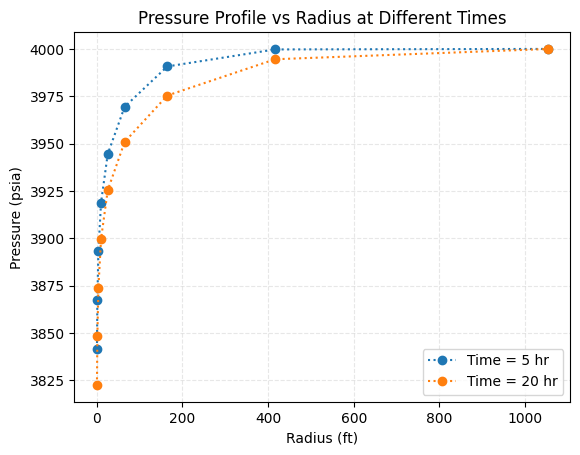

In [53]:
# Calculate r values for the requested radii grid
# r = rw * exp((n/N) * ln(re/rw)) for n = 1..N (N=9)
N = 9
n = np.arange(1, N + 1)
re = drainage_radius_from_area(A)
r = rw * np.exp((n / N) * np.log(re / rw))

# Transient pressure profile at each time (these times are < t_inf, so IARF is appropriate)
times_profile = [5, 20]
pressure_profiles = {}
for t_hr in times_profile:
    pressure_profiles[f'P_{t_hr}hr'] = []
    for radius in r:
        tD = 0.0002637 * k * t_hr / (phi * mu * ct * rw**2)
        rD = radius / rw
        PD = -0.5 * expi(-rD**2 / (4 * tD))
        deltaP = 141.2 * (q * Bo * mu) / (k * h) * PD
        P_r = Pi - deltaP
        pressure_profiles[f'P_{t_hr}hr'].append(P_r)
    plt.plot(r, pressure_profiles[f'P_{t_hr}hr'], label=f'Time = {t_hr} hr', marker='o', linestyle=':')

plt.xlabel('Radius (ft)')
plt.ylabel('Pressure (psia)')
plt.title('Pressure Profile vs Radius at Different Times')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.3)
plt.show()

### 3)

Calculate the flowing bottomhole pressures at t(hrs) = 0.25,0.5,0.75,1,5,10,20,30

In [54]:
times_drawdown = [0.25, 0.5, 0.75, 1, 5, 10, 20, 30]
pwf_drawdown = []
for t_hr in times_drawdown:
    Pwf = pwf_bounded_piecewise(t_hr, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0)
    print(f'Time: {t_hr:.2f} hr, Pwf: {float(Pwf):.0f} psia')
    pwf_drawdown.append(float(Pwf))

Time: 0.25 hr, Pwf: 3858 psia
Time: 0.50 hr, Pwf: 3848 psia
Time: 0.75 hr, Pwf: 3842 psia
Time: 1.00 hr, Pwf: 3838 psia
Time: 5.00 hr, Pwf: 3816 psia
Time: 10.00 hr, Pwf: 3806 psia
Time: 20.00 hr, Pwf: 3797 psia
Time: 30.00 hr, Pwf: 3791 psia


### 4)

Analyze your calculated bottomhole pressures graphically and estimate the formation permeability and initial reservoir pressure.

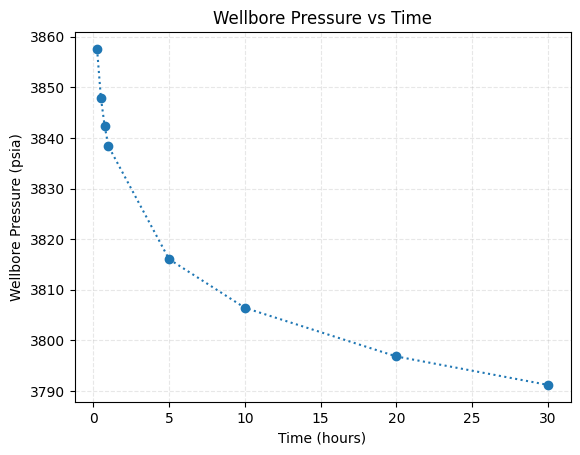

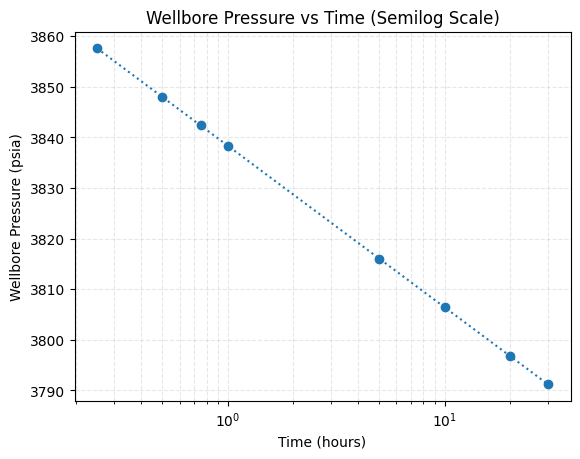

Slope of semilog plot (early-time): -31.92 psi/log-cycle
Estimated Permeability: 55.01 md
Estimated Initial Reservoir Pressure: 3999.92 psia


In [55]:
# Plot the raw data to visualize
plt.figure()
plt.plot(times_drawdown, pwf_drawdown, marker='o', linestyle=':')
plt.xlabel('Time (hours)')
plt.ylabel('Wellbore Pressure (psia)')
plt.title('Wellbore Pressure vs Time')
plt.grid(which='both', linestyle='--', alpha=0.3)
plt.show()

# Plot as semilog to get straight line (early-time)
plt.figure()
plt.semilogx(times_drawdown, pwf_drawdown, marker='o', linestyle=':')
plt.xlabel('Time (hours)')
plt.ylabel('Wellbore Pressure (psia)')
plt.title('Wellbore Pressure vs Time (Semilog Scale)')
plt.grid(which='both', linestyle='--', alpha=0.3)
plt.show()

# Fit only early-time (IARF) points: t <= t_inf from Q1
t_inf_hr = t_inf  # computed in Q1 cell
t_arr = np.asarray(times_drawdown, dtype=float)
p_arr = np.asarray(pwf_drawdown, dtype=float)
early_mask = (t_arr > 0) & (t_arr <= min(10.0, t_inf_hr))
slope, intercept = np.polyfit(np.log10(t_arr[early_mask]), p_arr[early_mask], 1)
print(f'Slope of semilog plot (early-time): {slope:.2f} psi/log-cycle')

# Estimate permeability from slope: m = -162.6 (qBoμ)/(kh)
k_estimated = -162.6 * (q * Bo * mu) / (slope * h)
print(f'Estimated Permeability: {k_estimated:.2f} md')

# Estimate Initial Reservoir Pressure (approximate; assumes the constant used in class notes and skin ~ 0)
idx_1hr = np.where(np.isclose(t_arr, 1.0))[0]
if len(idx_1hr) > 0:
    Pwf_1hr = p_arr[idx_1hr[0]]
    Pi_estimated = Pwf_1hr - slope * (np.log10(k_estimated/(phi*mu*ct*rw**2)) - 3.23)
    print(f'Estimated Initial Reservoir Pressure: {Pi_estimated:.2f} psia')
else:
    print('No t=1 hr point found for Pi estimate.')

### 5)

Calculate the time interval for late transient flow.

In [56]:
# Late transient flow: approximate window between boundary effects (end of IARF) and pseudo-steady state (PSS).
# We use the slide-based estimate for end of IARF (already computed as t_inf in Q1) and
# a common rule-of-thumb that PSS begins when t_DA = 0.25, where t_DA = 0.0002637*k*t / (phi*mu*ct*re^2).

t_inf_hr = t_inf
re_ft = drainage_radius_from_area(A)
t_pss_hr = 0.25 * (phi * mu * ct * re_ft**2) / (0.0002637 * k)
print(f'End of infinite-acting radial flow (boundary begins): t_inf ≈ {t_inf_hr:.1f} hr')
print(f'Approximate start of pseudo-steady state (t_DA≈0.25): t_pss ≈ {t_pss_hr:.1f} hr')
print(f'Late transient flow interval: {t_inf_hr:.1f} hr to {t_pss_hr:.1f} hr')

End of infinite-acting radial flow (boundary begins): t_inf ≈ 34.5 hr
Approximate start of pseudo-steady state (t_DA≈0.25): t_pss ≈ 86.0 hr
Late transient flow interval: 34.5 hr to 86.0 hr


### 6)

Calculate the flowing bottomhole pressure at t = 40, 60, 80 and 100 hours.

In [57]:
new_times = [40, 60, 80, 100]
times_drawdown += new_times
for t_hr in new_times:
    Pwf = pwf_bounded_piecewise(t_hr, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0)
    print(f'Time: {t_hr:.2f} hr, Pwf: {float(Pwf):.0f} psia')
    pwf_drawdown.append(float(Pwf))

Time: 40.00 hr, Pwf: 3783 psia
Time: 60.00 hr, Pwf: 3780 psia
Time: 80.00 hr, Pwf: 3777 psia
Time: 100.00 hr, Pwf: 3773 psia


### 7)

Suppose the calculated pressures were measured, analyze the pressure data graphically and estimate the average reservoir pressure, formation permeability and the drainage area. (Hint: you need a trial and error procedure). Comment on any difficulties that arise.

Early-time semilog slope m = -31.92 psi/log-cycle
k from early-time semilog: 55.01 mD
A from late-time dp/dt: 80.00 acres

Trial-and-error (least squares) fit to p_wf(t):
Pi ≈ 4000.00 psia
k  ≈ 55.00 mD
A  ≈ 80.00 acres
re ≈ 1053.2 ft
t_inf (from fitted params) ≈ 34.5 hr
Average reservoir pressure (mean over late points) p_avg ≈ 3989 psia
Average reservoir pressure at 100 hr p_avg(100hr) ≈ 3984 psia


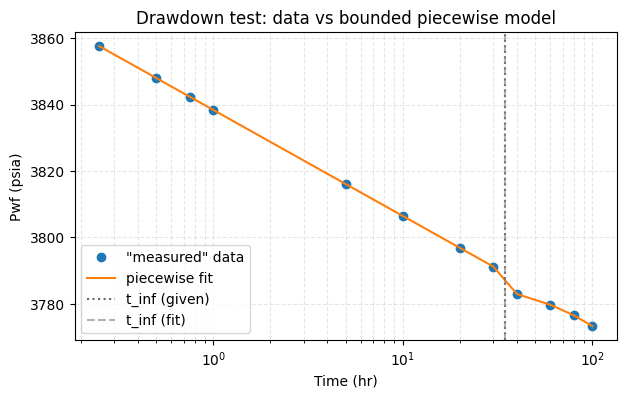

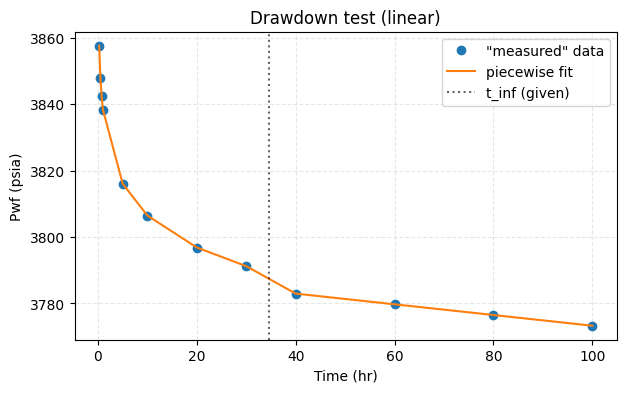


Comment / difficulty:
- If pressures are generated/fit with an infinite-acting model only, A is not identifiable because A never appears in that solution.
- With bounded/pseudo-steady behavior present (late-time depletion), A can be inferred from dp/dt or by fitting a bounded model.


In [58]:
# - Use early-time semilog straight line (t < t_inf) to estimate k.
# - Use late-time depletion (pseudo-steady) behavior to estimate A and p_avg(t).
# - "Trial and error" can be implemented by fitting (Pi, k, A) to the measured p_wf(t).

# Use computed drawdown pressures as the measured dataset
t_data_hr = np.asarray(times_drawdown, dtype=float)
p_data_psia = np.asarray(pwf_drawdown, dtype=float)

# --- Early-time k estimate using slope ---
t_inf_hr = t_inf
early_mask = (t_data_hr > 0) & (t_data_hr <= min(10.0, t_inf_hr))
m, b = np.polyfit(np.log10(t_data_hr[early_mask]), p_data_psia[early_mask], 1)
k_hat_md = -162.6 * (q * Bo * mu) / (m * h)

# --- Late-time A estimate from dp/dt using times beyond t_inf ---
late_mask = (t_data_hr >= max(40.0, t_inf_hr))
if np.sum(late_mask) >= 2:
    slope_hr, intercept_hr = np.polyfit(t_data_hr[late_mask], p_data_psia[late_mask], 1)
    slope_day = slope_hr * 24.0
    A_hat_from_slope = (q * Bo) * 5.615 / (abs(slope_day) * 43560.04 * h * phi * ct)
else:
    slope_hr, intercept_hr, slope_day, A_hat_from_slope = np.nan, np.nan, np.nan, np.nan

# --- Trial & error: fit (Pi, k, A) to the drawdown curve ---
def residuals(params):
    Pi_try, k_try, A_try = params
    model = pwf_bounded_piecewise(t_data_hr, q, Pi_try, A_try, k_try, h, phi, mu, ct, rw, Bo, skin=0.0)
    return np.asarray(model, dtype=float) - p_data_psia

Pi0 = float(np.max(p_data_psia) + 50.0)
k0 = float(max(1.0, k_hat_md))
A0 = float(A_hat_from_slope) if np.isfinite(A_hat_from_slope) else float(A)
x0 = np.array([Pi0, k0, A0], dtype=float)

# Bounds: Pi must be >= max observed, k and A positive
lb = np.array([np.max(p_data_psia), 1e-3, 1e-3], dtype=float)
ub = np.array([1e6, 1e6, 1e6], dtype=float)

fit = opt.least_squares(residuals, x0, bounds=(lb, ub))
Pi_fit, k_fit, A_fit = fit.x
re_fit_ft = drainage_radius_from_area(A_fit)
t_inf_fit_hr = t_infinite_acting_hr(phi, mu, ct, A_fit, k_fit)

# Average reservoir pressure estimate at late times (pseudo-steady assumption)
pavg_late = pavg_closed_system(Pi_fit, t_data_hr[late_mask], q, Bo, A_fit, h, phi, ct) if np.any(late_mask) else np.array([])
pavg_at_100hr = float(pavg_closed_system(Pi_fit, 100.0, q, Bo, A_fit, h, phi, ct))
# --- Output results ---
print(f'Early-time semilog slope m = {m:.2f} psi/log-cycle')
print(f'k from early-time semilog: {k_hat_md:.2f} mD')

if np.isfinite(A_hat_from_slope):
    print(f'A from late-time dp/dt: {A_hat_from_slope:.2f} acres')
else:
    print('A from late-time dp/dt: not available (insufficient late-time points)')

print('\nTrial-and-error (least squares) fit to p_wf(t):')
print(f'Pi ≈ {Pi_fit:.2f} psia')
print(f'k  ≈ {k_fit:.2f} mD')
print(f'A  ≈ {A_fit:.2f} acres')
print(f're ≈ {re_fit_ft:.1f} ft')
print(f't_inf (from fitted params) ≈ {t_inf_fit_hr:.1f} hr')
if len(pavg_late) > 0:
    print(f'Average reservoir pressure (mean over late points) p_avg ≈ {float(np.mean(pavg_late)):.0f} psia')
print(f'Average reservoir pressure at 100 hr p_avg(100hr) ≈ {pavg_at_100hr:.0f} psia')

# --- Plots: data vs fitted model ---
p_fit_curve = pwf_bounded_piecewise(t_data_hr, q, Pi_fit, A_fit, k_fit, h, phi, mu, ct, rw, Bo, skin=0.0)

plt.figure(figsize=(7, 4))
plt.semilogx(t_data_hr, p_data_psia, 'o', label='"measured" data')
plt.semilogx(t_data_hr, p_fit_curve, '-', label='piecewise fit')
plt.axvline(t_inf_hr, color='k', linestyle=':', alpha=0.6, label='t_inf (given)')
plt.axvline(t_inf_fit_hr, color='gray', linestyle='--', alpha=0.6, label='t_inf (fit)')
plt.xlabel('Time (hr)')
plt.ylabel('Pwf (psia)')
plt.title('Drawdown test: data vs bounded piecewise model')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(t_data_hr, p_data_psia, 'o', label='"measured" data')
plt.plot(t_data_hr, p_fit_curve, '-', label='piecewise fit')
plt.axvline(t_inf_hr, color='k', linestyle=':', alpha=0.6, label='t_inf (given)')
plt.xlabel('Time (hr)')
plt.ylabel('Pwf (psia)')
plt.title('Drawdown test (linear)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.show()

print('\nComment / difficulty:')
print('- If pressures are generated/fit with an infinite-acting model only, A is not identifiable because A never appears in that solution.')
print('- With bounded/pseudo-steady behavior present (late-time depletion), A can be inferred from dp/dt or by fitting a bounded model.')

### 8)

Calculate and plot the pressure profiles at t = 300 hours and t = 100 days.

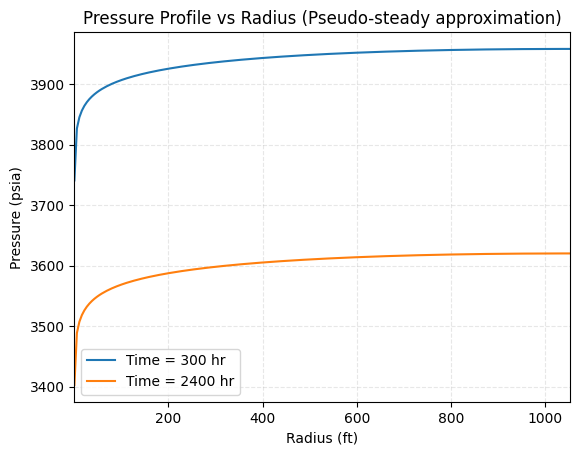

In [59]:
times_profile_late = [300.0, 100.0 * 24.0]  # hours
re_ft = drainage_radius_from_area(A)
r_profile = np.linspace(rw, re_ft, 200)

pressure_profiles_late = {}
for t_hr in times_profile_late:
    p_r = p_profile_pseudosteady(t_hr, r_profile, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0)
    pressure_profiles_late[f'P_{int(t_hr)}hr'] = p_r
    plt.plot(r_profile, p_r, label=f'Time = {t_hr:.0f} hr')

plt.xlabel('Radius (ft)')
plt.xlim(rw, re_ft)
plt.ylabel('Pressure (psia)')
plt.title('Pressure Profile vs Radius (Pseudo-steady approximation)')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.3)
plt.show()

### 9)

Calculate the average reservoir pressure at t = 100 

In [60]:
t_100d_hr = 100.0 * 24.0
avg_P = float(pavg_closed_system(Pi, t_100d_hr, q, Bo, A, h, phi, ct))
print(f'Average reservoir pressure at 100 days: {avg_P:.0f} psia')

# (Optional check) The pseudo-steady profile should have an average close to avg_P by construction.
# Area-weighted mean over a disk: <p> = ∫ p(r) 2πr dr / ∫ 2πr dr
re_ft = drainage_radius_from_area(A)
r_check = np.linspace(rw, re_ft, 2000)
p_check = p_profile_pseudosteady(t_100d_hr, r_check, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0)
p_area_avg = float(np.trapezoid(p_check * r_check, r_check) / np.trapezoid(r_check, r_check))
print(f'Area-weighted average from pseudo-steady profile (sanity check): {p_area_avg:.0f} psia')

Average reservoir pressure at 100 days: 3613 psia
Area-weighted average from pseudo-steady profile (sanity check): 3613 psia


### 10)

Calculate the pressure drawdown and the ideal productivity index for this well.

In [61]:
# Q10) Pressure drawdown and ideal productivity index
#
# "Pressure drawdown" here is Δp(t) = Pi - Pwf(t).
# "Ideal PI" here is the pseudo-steady (late-time) productivity index for a centered well,
# with skin = 0: J_ideal = q / (p_avg - p_wf) = (k h) / [141.2 B μ (ln(re/rw) - 0.75)].

re_ft = drainage_radius_from_area(A)

dp_pss_const = 141.2 * (q * Bo * mu) / (k * h) * (np.log(re_ft / rw) - 0.75)  # psia
J_ideal_stbd_psi = q / dp_pss_const

Pwf_1hr = float(pwf_bounded_piecewise(1.0, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0))
dp_1hr = Pi - Pwf_1hr
J_1hr = q / dp_1hr

# Sanity check at 100 days (pseudo-steady applies): use p_avg rather than Pi
pavg_100d = float(pavg_closed_system(Pi, 100.0 * 24.0, q, Bo, A, h, phi, ct))
Pwf_100d = float(pwf_bounded_piecewise(100.0 * 24.0, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0))
dp_100d_vs_pavg = pavg_100d - Pwf_100d
J_100d_vs_pavg = q / dp_100d_vs_pavg

print(f"Centered-well pseudo-steady drawdown constant (p_avg - p_wf): {dp_pss_const:.1f} psi")
print(f"Ideal (pseudo-steady) PI, skin=0: J = {J_ideal_stbd_psi:.3f} stb/d/psi")
print("\n")
print(f"At t=1 hr: Pwf = {Pwf_1hr:.1f} psia, Δp = Pi - Pwf = {dp_1hr:.1f} psi, J(t) = {J_1hr:.3f} stb/d/psi")
print(f"At t=100 d: p_avg = {pavg_100d:.1f} psia, Pwf = {Pwf_100d:.1f} psia, (p_avg-Pwf) = {dp_100d_vs_pavg:.1f} psi, J = {J_100d_vs_pavg:.3f} stb/d/psi")

Centered-well pseudo-steady drawdown constant (p_avg - p_wf): 210.6 psi
Ideal (pseudo-steady) PI, skin=0: J = 1.424 stb/d/psi


At t=1 hr: Pwf = 3838.4 psia, Δp = Pi - Pwf = 161.6 psi, J(t) = 1.856 stb/d/psi
At t=100 d: p_avg = 3613.3 psia, Pwf = 3402.7 psia, (p_avg-Pwf) = 210.6 psi, J = 1.424 stb/d/psi


### 11)

Calculate the flowing bottomhole pressures at t=150, 300, 400, 500 and 600 hours.

In [62]:
# Q11) Flowing bottomhole pressures at t = 150, 300, 400, 500 and 600 hours

more_times = [150, 300, 400, 500, 600]
for t_hr in more_times:
    Pwf = pwf_bounded_piecewise(t_hr, q, Pi, A, k, h, phi, mu, ct, rw, Bo, skin=0.0)
    print(f'Time: {t_hr:.2f} hr, Pwf: {float(Pwf):.0f} psia')
    # Keep adding to the drawdown dataset so later questions can reuse it
    times_drawdown.append(t_hr)
    pwf_drawdown.append(float(Pwf))

Time: 150.00 hr, Pwf: 3765 psia
Time: 300.00 hr, Pwf: 3741 psia
Time: 400.00 hr, Pwf: 3725 psia
Time: 500.00 hr, Pwf: 3709 psia
Time: 600.00 hr, Pwf: 3693 psia


### 12)

Suppose the calculated bottomhole pressures were actually measured, analyze the pressure data graphically and estimate the drainage area and the shape factor.

#### Shape factor equation (Dake)
We use Dake’s pseudo-steady (closed-boundary) drawdown form with the drainage shape factor $C_A$ (Dake, *Fundamentals of Reservoir Engineering*):
$$
p_{wf}=p_i-\frac{q\mu B}{2\pi k h}\left[\frac{1}{2}\ln\left(\frac{4A}{\gamma C_A r_w^2}\right)+\frac{2\pi k t}{\phi\mu c_t A}+s\right]
$$
In the code below, the time-dependent depletion term is handled via material balance as $\bar p(t)$, so we rearrange to the equivalent constant pseudo-steady drawdown relationship:
$$
\bar p(t)-p_{wf}(t)=\frac{q\mu B}{2\pi k h}\left[\frac{1}{2}\ln\left(\frac{4A}{\gamma C_A r_w^2}\right)+s\right]
$$
where Dake’s $\gamma=e^{0.57721566}\approx1.781$.

Late-time fit window starts at t >= 86.0 hr (N=6 points)
Late-time linear fit: p_wf = 3789.39 + (-0.161128) t_hr
---
Estimated drainage area A ≈ 80.00 acres
Estimated drainage radius re ≈ 1053.2 ft
Estimated shape factor C_A ≈ 31.62 (dimensionless)
Reference (circular centered-well, Dake definition) C_A ≈ 31.62


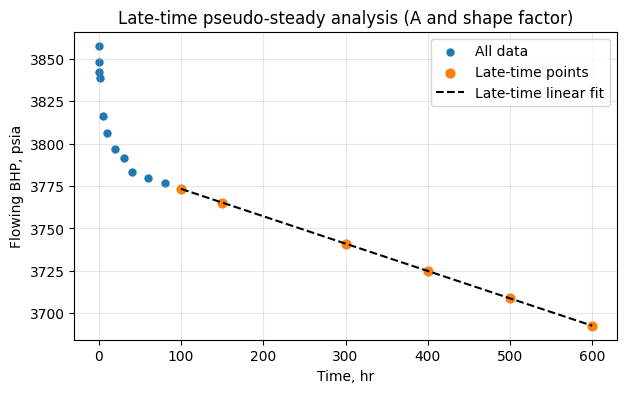

In [63]:
# Late-time pseudo-steady for a closed system gives a linear p_wf vs time:
#   p_wf(t) = (Pi - Δp_const) - (qB)/(24 PV ct) * t_hr
# so the slope gives PV (and thus A), and the intercept gives the constant drawdown term.
#
# For the shape factor, we use Dake's definition:
#   Δp_const = (141.2 qBμ)/(kh) * [ 1/2 ln(4A/(γ C_A r_w^2)) + s ]

# Use the drawdown dataset built earlier (Q3/Q6/Q11)
t_data_hr = np.asarray(times_drawdown, dtype=float)
p_data_psia = np.asarray(pwf_drawdown, dtype=float)

t_late_start = float(t_pss_hr)

late_mask = t_data_hr >= t_late_start
if late_mask.sum() < 3:
    # Fallback: just take the last 5 points
    late_mask = np.zeros_like(t_data_hr, dtype=bool)
    late_mask[-5:] = True

t_late = t_data_hr[late_mask]
p_late = p_data_psia[late_mask]

# Linear regression: p_wf = b + m t
m, b = np.polyfit(t_late, p_late, 1)

# Convert slope to PV and area
# slope m = -(qB)/(24 PV ct)  => PV = -(qB)/(24 ct m)
PV_rb = -(q * Bo) / (24.0 * ct * m)
A_hat_acres = PV_rb * 5.615 / (43560.04 * h * phi)
re_hat_ft = drainage_radius_from_area(A_hat_acres)

# Constant drawdown term from intercept
dp_const_psia = Pi - b
F = (k * h / (141.2 * q * Bo * mu)) * dp_const_psia  # dimensionless

# Dake/Dietz shape factor from: F = 0.5 ln(4A/(γ C_A rw^2)) + s
# (with s=0 here) => C_A = 4A/(γ rw^2 exp(2F))
gamma_euler = float(np.exp(0.5772156649015329))  # ≈ 1.781
A_hat_ft2 = A_hat_acres * 43560.04
C_A_hat = (4.0 * A_hat_ft2) / (gamma_euler * rw**2 * np.exp(2.0 * F))

# Reference: equivalent circular centered-well C_A under Dake's definition
C_A_circular_center = float((4.0 * np.pi / gamma_euler) * np.exp(1.5))

print(f"Late-time fit window starts at t >= {t_late_start:.1f} hr (N={t_late.size} points)")
print(f"Late-time linear fit: p_wf = {b:.2f} + ({m:.6f}) t_hr")
print("---")
print(f"Estimated drainage area A ≈ {A_hat_acres:.2f} acres")
print(f"Estimated drainage radius re ≈ {re_hat_ft:.1f} ft")
print(f"Estimated shape factor C_A ≈ {C_A_hat:.2f} (dimensionless)")
print(f"Reference (circular centered-well, Dake definition) C_A ≈ {C_A_circular_center:.2f}")

# Graphical check
plt.figure(figsize=(7, 4))
plt.scatter(t_data_hr, p_data_psia, s=25, label='All data')
plt.scatter(t_late, p_late, s=40, label='Late-time points')
plt.plot(t_late, b + m * t_late, 'k--', label='Late-time linear fit')
plt.xlabel('Time, hr')
plt.ylabel('Flowing BHP, psia')
plt.title('Late-time pseudo-steady analysis (A and shape factor)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 13)

Calculate the flowing bottomhole pressure at t = 100 days given that the drainage shape and well location are (a) well at the center of a square and (b) well at the center of a quadrant of a 2 x 1 rectangle.

In [64]:
# We use the pseudo-steady form with a Dietz/Dake-style shape factor C_A:
#   p_wf = p_avg - (141.2 qBμ)/(kh) * [ 1/2 ln(4A/(γ C_A r_w^2)) + s ]
# where γ = e^0.57721566 ≈ 1.781 (Dake notation).


# Time
T_100d_hr = 100.0 * 24.0
pavg_100d = float(pavg_closed_system(Pi, T_100d_hr, q, Bo, A, h, phi, ct))


C_A_square_center = 30.9
C_A_quadrant_of_2x1_rectangle_center = 2.07

Pwf_100d_square = float(
    pwf_pseudosteady_shape_factor(
        T_100d_hr, q, Pi, A, k, h, phi, mu, ct, rw, Bo,
        shape_factor_CA=C_A_square_center,
        skin=0.0,
    )
)

Pwf_100d_quadrant = float(
    pwf_pseudosteady_shape_factor(
        T_100d_hr, q, Pi, A, k, h, phi, mu, ct, rw, Bo,
        shape_factor_CA=C_A_quadrant_of_2x1_rectangle_center,
        skin=0.0,
    )
)

print(f"At 100 days: p_avg ≈ {pavg_100d:.1f} psia")
print("---")
print(f"(a) Well at center of a square: C_A={C_A_square_center:.2f} -> Pwf ≈ {Pwf_100d_square:.1f} psia")
print(f"(b) Well at center of a quadrant of a 2x1 rectangle: C_A={C_A_quadrant_of_2x1_rectangle_center:.2f} -> Pwf ≈ {Pwf_100d_quadrant:.1f} psia")

# Reference: equivalent circular centered-well C_A under Dake's definition
_gamma_euler = float(np.exp(0.5772156649015329))
C_A_circular_center = float((4.0 * np.pi / _gamma_euler) * np.exp(1.5))
Pwf_100d_circular = float(
    pwf_pseudosteady_shape_factor(
        T_100d_hr, q, Pi, A, k, h, phi, mu, ct, rw, Bo,
        shape_factor_CA=C_A_circular_center,
        skin=0.0,
    )
)
print("---")
print(f"(reference) Circular centered well (Dake definition): C_A={C_A_circular_center:.2f} -> Pwf ≈ {Pwf_100d_circular:.1f} psia")

At 100 days: p_avg ≈ 3613.3 psia
---
(a) Well at center of a square: C_A=30.90 -> Pwf ≈ 3402.4 psia
(b) Well at center of a quadrant of a 2x1 rectangle: C_A=2.07 -> Pwf ≈ 3364.9 psia
---
(reference) Circular centered well (Dake definition): C_A=31.62 -> Pwf ≈ 3402.7 psia
